# ML for Economic Analysis
## Project 2: Melbourne Housing Market

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.base import TransformerMixin
from collections import Counter

In [ ]:
# Imports
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,KFold
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn import metrics
%load_ext google.colab.data_table

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

**Data import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
# Load the data set
df = pd.read_csv('/content/drive/MyDrive/MLfEA_FT2020/project 2/Data/Melbourne_housing_FULL.csv')

In [ ]:
# Show the first few rows of the data
df.head()

In [ ]:
# View information on columns
df.info()

In [ ]:
col_uni_val={}
for i in df.columns:
    col_uni_val[i] = len(df[i].unique())

import pprint
pprint.pprint(col_uni_val)   

# Handling missing values

Imputation fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely. Additionally, we dropped the target variable's missing values (Price). 

In [ ]:
df = df.dropna(subset=['Price'])

In [ ]:
df_dropped = df.dropna()

In [ ]:
# Have a look at the missing values
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Lattitude         6254
Longtitude        6254
Regionname           3
Propertycount        3
dtype: int64

In [ ]:
df_dropped.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

### Impute missing values: distinguishing between continuous and categorical

To use mean values for numeric columns and the most frequent value for non-numeric columns you could do something like this. You could further distinguish between integers and floats. I guess it might make sense to use the median for integer columns instead.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

df_imputed = DataFrameImputer().fit_transform(df)
y_pds = df_imputed.Price

Check whether there are duplicated entries

In [ ]:
df.duplicated().sum()

0

## Intro

Before data preprocessing (i.e. dropping and imputation of NANs) the raw data is explored.

In [ ]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


Type of data

In [ ]:
df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

# EDA - Raw Dataset

## Geography Related - 9

In [ ]:
gr = df.loc[:, ["Lattitude", "Longtitude", "Address", "Suburb", "Postcode", "CouncilArea", "Propertycount", "Regionname", "Distance", "Price"]]
gr.shape

(27247, 10)

In [ ]:
i = 0
for column in gr:
  print(i, df.loc[:, column].nunique())
  i = i+1

0 11366
1 12275
2 26751
3 345
4 209
5 33
6 336
7 8
8 213
9 2871


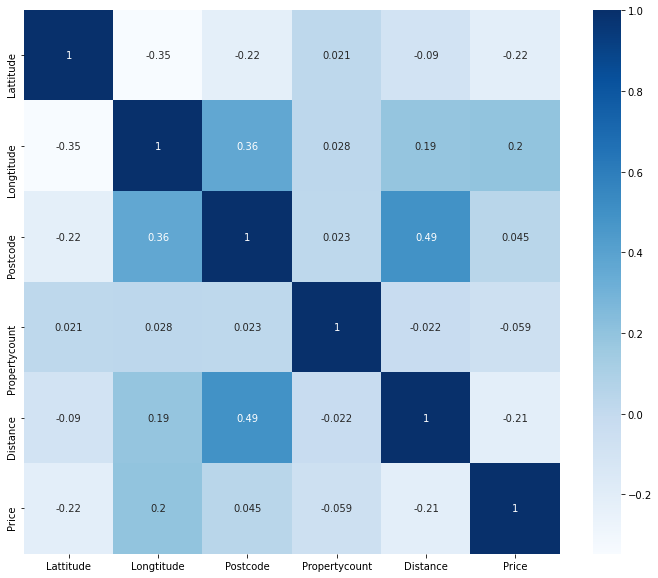

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = gr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

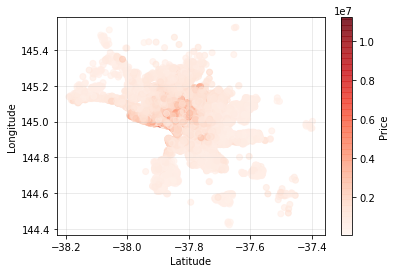

In [ ]:
plt.scatter(gr.loc[:, "Lattitude"], gr.loc[:, "Longtitude"], c = gr.loc[:, "Price"], alpha = 0.60, cmap= "Reds")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(axis = "y", alpha = 0.3)
plt.grid(axis = "x", alpha = 0.3)
plt.colorbar(label = "Price")

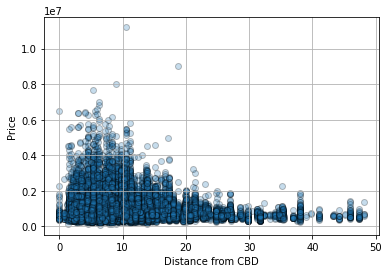

In [ ]:
plt.scatter(df["Distance"], df["Price"], alpha = 0.25, edgecolors = "black")
plt.grid(axis = "x")
plt.grid(axis = "y")
plt.xlabel("Distance from CBD")
plt.ylabel("Price")
fig = plt.title("")

Distribution of "Price"

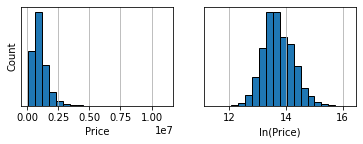

In [ ]:
x = df.loc[:, "Price"]
ln_x = np.log(x)

plt.subplot(2, 2, 1)
plt.hist(x, bins = 20, edgecolor = "black")
plt.ylabel("Count")
plt.xlabel("Price")
plt.yticks([])
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(ln_x, bins = 20, edgecolor = "black")
plt.xlabel('ln(Price)')
plt.ylabel('')
plt.yticks([])
plt.grid(True)

plt.show()

## Seller Related - 3

In [ ]:
sr = df.loc[:, ["SellerG", "Method", "Date", "Price"]]
sr.shape

(27247, 4)

In [ ]:
i = 0
for column in sr:
  print(i, df.loc[:, column].nunique())
  i = i+1

0 349
1 5
2 78
3 2871


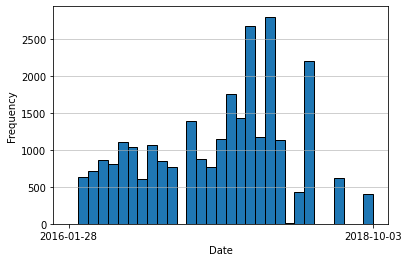

In [ ]:
sr['Date']= pd.to_datetime(sr['Date'])
min_date = sr["Date"].min()
max_date = sr["Date"].max()

plt.hist(sr.loc[:, "Date"], bins = 31, edgecolor = "black")
plt.xticks(ticks = [min_date, max_date])
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)

## Building-related - 8

In [ ]:
br = df.loc[:, ["Bedroom2", "Rooms", "Bathroom", "Car", "Landsize", "BuildingArea", "YearBuilt", "Price", "Type"]]
br.shape

(27247, 9)

In [ ]:
br.dtypes

Bedroom2        float64
Rooms             int64
Bathroom        float64
Car             float64
Landsize        float64
BuildingArea    float64
YearBuilt       float64
Price           float64
Type             object
dtype: object

In [ ]:
i = 0
for column in br:
  print(i, df.loc[:, column].nunique())
  i = i+1

0 14
1 12
2 10
3 13
4 1557
5 662
6 151
7 2871
8 3


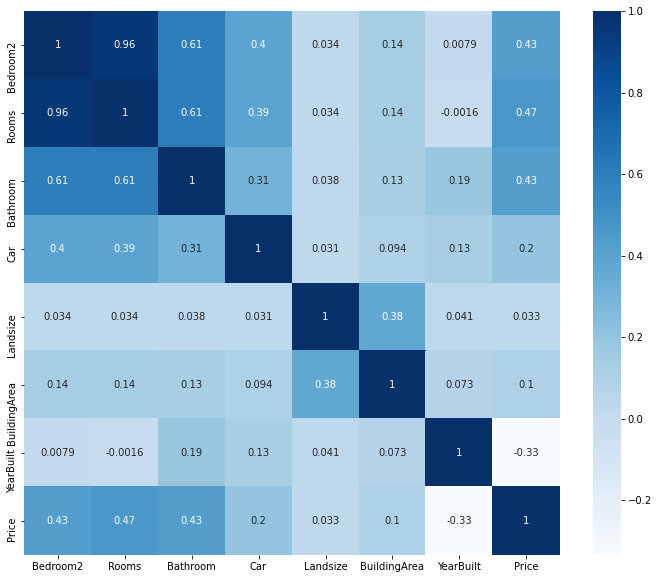

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = br.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
typ = br.loc[:, "Type"].unique()
typ

array(['h', 't', 'u'], dtype=object)

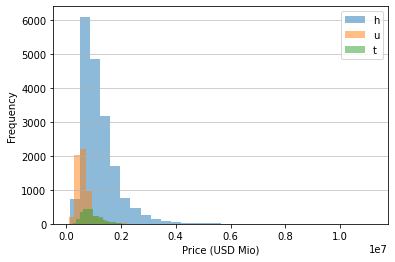

In [ ]:
h_df = df.loc[df["Type"] == "h", ["Price", "Type"]]
u_df = df.loc[df["Type"] == "u", ["Price", "Type"]]
t_df = df.loc[df["Type"] == "t", ["Price", "Type"]]

from matplotlib import pyplot

pyplot.hist(h_df.loc[:, "Price"], bins = 30, alpha=0.5, label='h')
pyplot.hist(u_df.loc[:, "Price"], bins = 30, alpha=0.5, label='u')
pyplot.hist(t_df.loc[:, "Price"], bins = 30, alpha=0.5, label='t')

pyplot.legend(loc='upper right')
pyplot.grid(axis='y', alpha=0.75)
pyplot.xlabel("Price (USD Mio)")
pyplot.ylabel("Frequency")
pyplot.show()

# Feature engineering and preprocessing

In [ ]:
# Remove variables that we don't need
# Address is removed as it is individual and has no predictive power
# Bedroom2 is removed as it should be the same as Rooms, but has more missing values
# Suburb name and Postcode are removed
# SellerG was removed (many different types, all sell both for high and low prices)
# Method was removed, as it has similar features to SellerG
df_imputed = df_imputed.drop(['Address', 'Bedroom2', 'Suburb', 'Postcode', 'SellerG', 'Method'], axis=1)

In [ ]:
df_dropped = df_dropped.drop(['Address', 'Bedroom2', 'Suburb', 'Postcode', 'SellerG', 'Method'], axis=1)

In [ ]:
# View information on columns
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          27247 non-null  int64  
 1   Type           27247 non-null  object 
 2   Price          27247 non-null  float64
 3   Date           27247 non-null  object 
 4   Distance       27247 non-null  float64
 5   Bathroom       27247 non-null  float64
 6   Car            27247 non-null  float64
 7   Landsize       27247 non-null  float64
 8   BuildingArea   27247 non-null  float64
 9   YearBuilt      27247 non-null  float64
 10  CouncilArea    27247 non-null  object 
 11  Lattitude      27247 non-null  float64
 12  Longtitude     27247 non-null  float64
 13  Regionname     27247 non-null  object 
 14  Propertycount  27247 non-null  float64
dtypes: float64(10), int64(1), object(4)
memory usage: 3.3+ MB


In [ ]:
#normalize the y values. We want to take the log in order to make sure our y values are normally distributed
df_imputed["Price"] = np.log1p(df_imputed["Price"])

In [ ]:
df_dropped["Price"] = np.log1p(df_dropped["Price"])

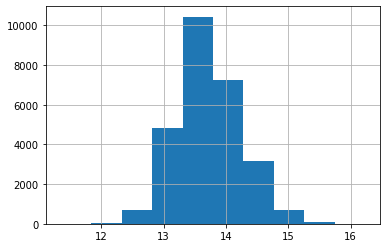

In [ ]:
histogram = df_imputed["Price"].hist()

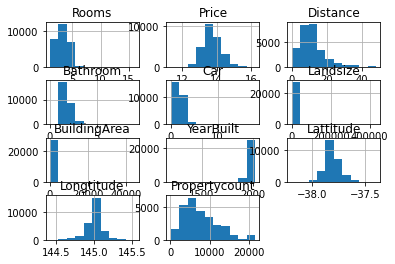

In [ ]:
hist_vars = df_imputed.hist()

In [ ]:
# Create variable number of years since building
df_imputed['houseAge'] = 2020-df_imputed['YearBuilt']

In [ ]:
df_dropped['houseAge'] = 2020-df_dropped['YearBuilt']

In [ ]:
# Change variable Date
df_imputed['Date'] = pd.to_datetime(df_imputed['Date'])

In [ ]:
# Create bins for every season
# Determine the day of the year
df_imputed['doy'] = df_imputed['Date'].dt.dayofyear
# Create bins
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

daje = []
for i in df_imputed['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    daje.append(season)   

#add the resulting column to the dataframe (after transforming it as a Series)
df_imputed['season']= pd.Series(daje)

In [ ]:
# Change variable Date
df_dropped['Date'] = pd.to_datetime(df_dropped['Date'])

In [ ]:
# Create bins for every season
# Determine the day of the year
df_dropped['doy'] = df_dropped['Date'].dt.dayofyear
# Create bins
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

daje = []
for i in df_dropped['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    daje.append(season)   

#add the resulting column to the dataframe (after transforming it as a Series)
df_dropped['season']= pd.Series(daje)

In [ ]:
df_imputed.head()

,Rooms,Type,Price,Date,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,houseAge,doy,season
1,2,h,14.207553,2016-03-12,2.5,1.0,1.0,202.0,156.834586,1966.609153,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,51.390847,72,spring
2,2,h,13.849913,2016-04-02,2.5,1.0,0.0,156.0,79.000000,1900.000000,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,118.000000,93,spring
4,3,h,14.197366,2017-04-03,2.5,2.0,0.0,134.0,150.000000,1900.000000,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,118.000000,93,spring
5,3,h,13.652993,2017-04-03,2.5,2.0,1.0,94.0,156.834586,1966.609153,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,51.390847,93,summer
6,4,h,14.285515,2016-04-06,2.5,1.0,2.0,120.0,142.000000,2014.000000,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,4.000000,97,summer


## drop columns

In [ ]:
# Drop useless variables
df_imputed = df_imputed.drop(['Propertycount', 'Date', 'YearBuilt', 'doy'], axis = 1)

In [ ]:
# Drop useless variables
df_dropped = df_dropped.drop(['Propertycount', 'Date', 'YearBuilt', 'doy'], axis = 1)

In [ ]:
# How many CouncilArea there are
df_imputed['CouncilArea'].nunique()

33

In [ ]:
# Create dummies for CouncilArea and Region Name
df_imputed = pd.get_dummies(df_imputed, columns = ['CouncilArea', 'Regionname', 'season', 'Type'])

In [ ]:
# Create dummies for CouncilArea and Region Name
df_dropped = pd.get_dummies(df_dropped, columns = ['CouncilArea', 'Regionname', 'season', 'Type'])

In [ ]:
df_imputed.head()

,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,houseAge,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,season_fall,season_spring,season_summer,season_winter,Type_h,Type_t,Type_u
1,2,14.207553,2.5,1.0,1.0,202.0,156.834586,-37.7996,144.9984,51.390847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,2,13.849913,2.5,1.0,0.0,156.0,79.000000,-37.8079,144.9934,118.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,3,14.197366,2.5,2.0,0.0,134.0,150.000000,-37.8093,144.9944,118.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
5,3,13.652993,2.5,2.0,1.0,94.0,156.834586,-37.7969,144.9969,51.390847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
6,4,14.285515,2.5,1.0,2.0,120.0,142.000000,-37.8072,144.9941,4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
# Put Price in last column
cols = df_imputed.columns.tolist()
cols = cols[0:1] + cols[2:-1] + cols[1:2]
cols

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'Lattitude',
 'Longtitude',
 'houseAge',
 'CouncilArea_Banyule City Council',
 'CouncilArea_Bayside City Council',
 'CouncilArea_Boroondara City Council',
 'CouncilArea_Brimbank City Council',
 'CouncilArea_Cardinia Shire Council',
 'CouncilArea_Casey City Council',
 'CouncilArea_Darebin City Council',
 'CouncilArea_Frankston City Council',
 'CouncilArea_Glen Eira City Council',
 'CouncilArea_Greater Dandenong City Council',
 'CouncilArea_Hobsons Bay City Council',
 'CouncilArea_Hume City Council',
 'CouncilArea_Kingston City Council',
 'CouncilArea_Knox City Council',
 'CouncilArea_Macedon Ranges Shire Council',
 'CouncilArea_Manningham City Council',
 'CouncilArea_Maribyrnong City Council',
 'CouncilArea_Maroondah City Council',
 'CouncilArea_Melbourne City Council',
 'CouncilArea_Melton City Council',
 'CouncilArea_Mitchell Shire Council',
 'CouncilArea_Monash City Council',
 'CouncilArea_Moonee Valley City C

In [ ]:
df_imputed = df_imputed[cols]
df_imputed.head()

,Rooms,Distance,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,houseAge,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,season_fall,season_spring,season_summer,season_winter,Type_h,Type_t,Price
1,2,2.5,1.0,1.0,202.0,156.834586,-37.7996,144.9984,51.390847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,14.207553
2,2,2.5,1.0,0.0,156.0,79.000000,-37.8079,144.9934,118.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,13.849913
4,3,2.5,2.0,0.0,134.0,150.000000,-37.8093,144.9944,118.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,14.197366
5,3,2.5,2.0,1.0,94.0,156.834586,-37.7969,144.9969,51.390847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,13.652993
6,4,2.5,1.0,2.0,120.0,142.000000,-37.8072,144.9941,4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,14.285515


In [ ]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Rooms                                       27247 non-null  int64  
 1   Distance                                    27247 non-null  float64
 2   Bathroom                                    27247 non-null  float64
 3   Car                                         27247 non-null  float64
 4   Landsize                                    27247 non-null  float64
 5   BuildingArea                                27247 non-null  float64
 6   Lattitude                                   27247 non-null  float64
 7   Longtitude                                  27247 non-null  float64
 8   houseAge                                    27247 non-null  float64
 9   CouncilArea_Banyule City Council            27247 non-null  uint8  
 10  CouncilAre

## data split

In [ ]:
# Imports
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_imputed.drop('Price', axis = 1), df_imputed['Price'], test_size = .20, random_state= 0)

print("Train: ", X_train.shape)
print("Test: ", X_test.shape)

Train:  (21797, 56)
Test:  (5450, 56)


In [ ]:
# Imports
from sklearn.model_selection import train_test_split

# Train Test Split
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(df_dropped.drop('Price', axis = 1), df_dropped['Price'], test_size = .20, random_state= 0)

print("Train: ", X_train_drop.shape)
print("Test: ", X_test_drop.shape)

Train:  (7109, 57)
Test:  (1778, 57)


## Scaling

In [ ]:
# Imports
from sklearn.preprocessing import RobustScaler

In [ ]:
# Transform
transformer = RobustScaler().fit(X_train)
X_train_scaled = transformer.transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [ ]:
# Transform
transformer = RobustScaler().fit(X_train_drop)
X_train_drop_scaled = transformer.transform(X_train_drop)
X_test_drop_scaled = transformer.transform(X_test_drop)

# ML Models

In [ ]:
# OLS benchmark
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression()
lm1.fit(X_train_scaled, y_train)

y_pred = lm1.predict(X_test_scaled)
print(metrics.mean_squared_error(y_test, y_pred))

0.07097488013235308


In [ ]:
# OLS benchmark dropping NAs
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression()
lm1.fit(X_train_drop_scaled, y_train_drop)

y_pred_drop = lm1.predict(X_test_drop_scaled)
print(metrics.mean_squared_error(y_test_drop, y_pred_drop))

0.06785815804560309


## No Tuning (Default)

In [ ]:
models = {
    'Lasso': {
        'model': Lasso()
    },
    'LinearRegression': {
        'model': LinearRegression()
    },
    'Ridge': {
        'model': Ridge()
    },
    'ElasticNet': {
        'model': ElasticNet()
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor()
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor()
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor()
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(n_estimators = 5, learning_rate = 1.2, loss = 'exponential', random_state = 2)
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(max_depth = 9, min_samples_split = 4, random_state = 1)
    },
    'XGBRegressor': {
        'model': XGBRegressor(n_estimators = 80, max_depth = 8, learning_rate = 0.3, random_state = 2)
    }
}

In [ ]:
# Add dictionary attributes
for model in models:
    models[model]['prediction'] = None
    models[model]['errors'] = {
        'mae': None,
        'mse': None,
        'rmse': None
    }
    models[model]['scores'] = {
        'r2': None
    }

In [ ]:
#Let's try our luck with a bunch of models
for model in models:
    print('Running ', models[model]['model'])
    models[model]['model'].fit(X_train_scaled, y_train)
    models[model]['predictions'] = models[model]['model'].predict(X_test_scaled)
    models[model]['errors']['mae'] = metrics.mean_absolute_error(y_test, models[model]['predictions'])
    models[model]['errors']['mse'] = metrics.mean_squared_error(y_test, models[model]['predictions'])
    models[model]['errors']['rmse'] = np.sqrt(models[model]['errors']['mse'])
    models[model]['scores']['r2'] = metrics.r2_score(y_test, models[model]['predictions'])
    print('MAE: ', models[model]['errors']['mae'])
    print('MSE: ', models[model]['errors']['mse'])
    print('RMSE: ', models[model]['errors']['rmse'])
    print('R2: ', models[model]['scores']['r2'])
    print('\n')

Running  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MAE:  0.3907737034687064
MSE:  0.2448550016302635
RMSE:  0.4948282546806149
R2:  0.07256334615815385


Running  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE:  0.20337104716175944
MSE:  0.0709748801323525
RMSE:  0.2664111111278066
R2:  0.7311686308284121


Running  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MAE:  0.20334310287995047
MSE:  0.07096256751453044
RMSE:  0.2663880018216482
R2:  0.7312152672989636


Running  ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
MAE:  0.3902986521

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


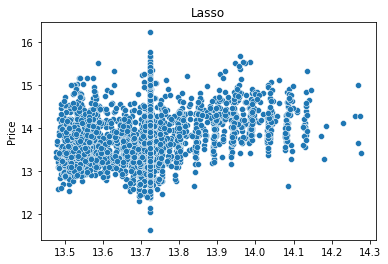

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


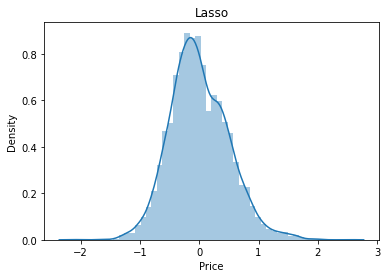

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


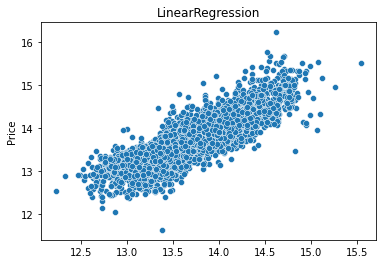

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


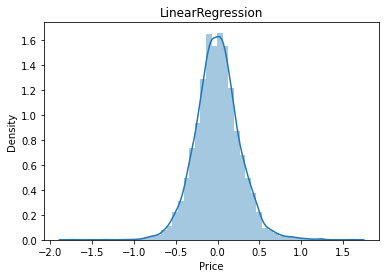

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


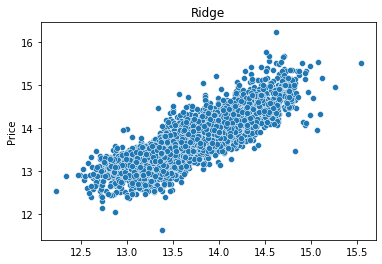

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


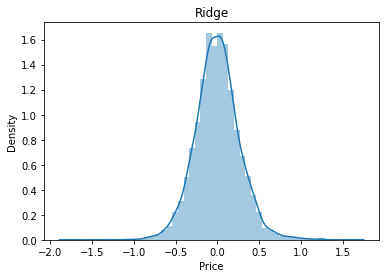

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


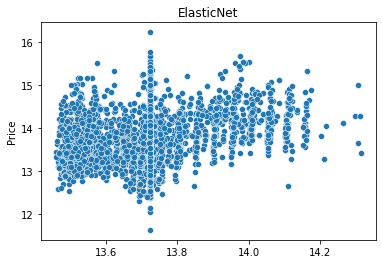

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


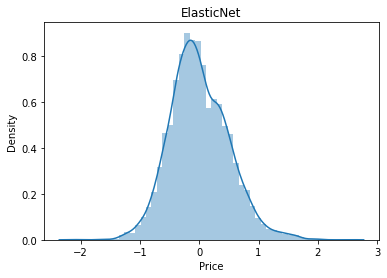

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


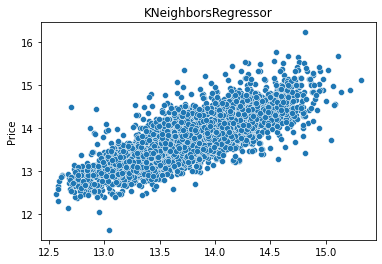

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


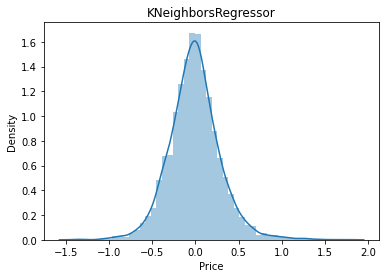

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


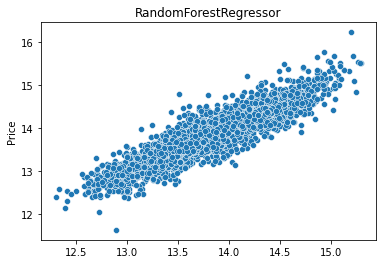

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


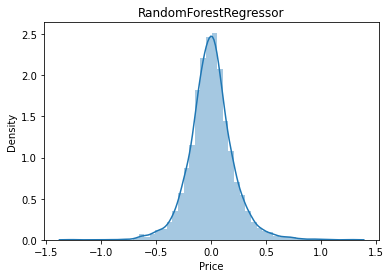

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


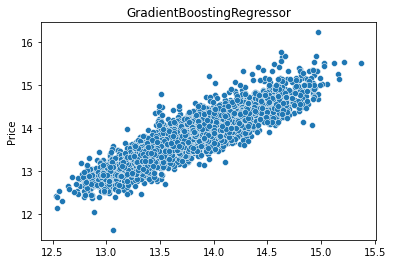

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


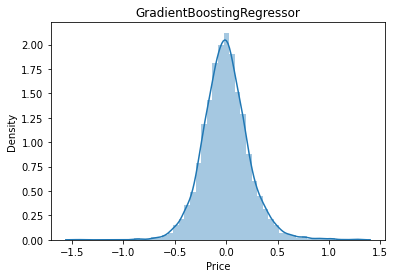

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


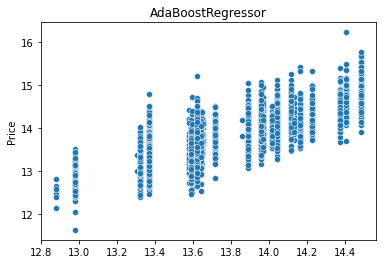

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


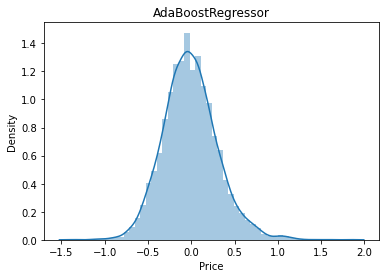

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


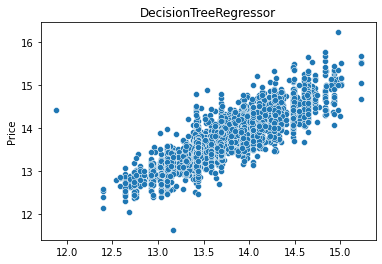

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


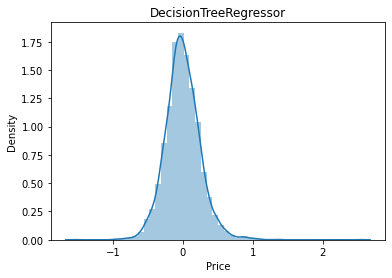

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


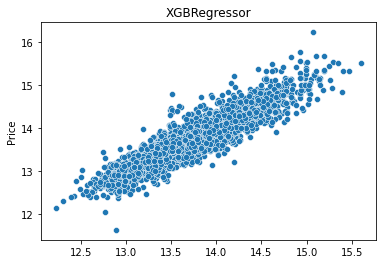

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


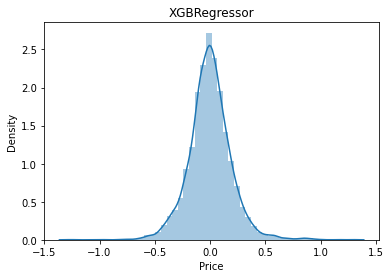

In [ ]:
# Analyse the Residuals
for index, model in enumerate(models):
    sns.scatterplot(models[model]['predictions'], y_test)
    plt.title(model)
    plt.show()
    
    sns.distplot((y_test - models[model]['predictions']))
    plt.title(model)
    plt.show()

In [ ]:
## OLS benchmark

## No Tuning (Default) - dropped NAs

In [ ]:
models = {
    'Lasso': {
        'model': Lasso()
    },
    'LinearRegression': {
        'model': LinearRegression()
    },
    'Ridge': {
        'model': Ridge()
    },
    'ElasticNet': {
        'model': ElasticNet()
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor()
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor()
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor()
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(n_estimators = 5, learning_rate = 1.2, loss = 'exponential', random_state = 2)
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(max_depth = 9, min_samples_split = 4, random_state = 1)
    },
    'XGBRegressor': {
        'model': XGBRegressor(n_estimators = 80, max_depth = 8, learning_rate = 0.3, random_state = 2)
    }
}

In [ ]:
# Add dictionary attributes
for model in models:
    models[model]['prediction'] = None
    models[model]['errors'] = {
        'mae': None,
        'mse': None,
        'rmse': None
    }
    models[model]['scores'] = {
        'r2': None
    }

In [ ]:
#Let's try our luck with a bunch of models
for model in models:
    print('Running ', models[model]['model'])
    models[model]['model'].fit(X_train_drop_scaled, y_train_drop)
    models[model]['predictions'] = models[model]['model'].predict(X_test_drop_scaled)
    models[model]['errors']['mae'] = metrics.mean_absolute_error(y_test_drop, models[model]['predictions'])
    models[model]['errors']['mse'] = metrics.mean_squared_error(y_test_drop, models[model]['predictions'])
    models[model]['errors']['rmse'] = np.sqrt(models[model]['errors']['mse'])
    models[model]['scores']['r2'] = metrics.r2_score(y_test_drop, models[model]['predictions'])
    print('MAE: ', models[model]['errors']['mae'])
    print('MSE: ', models[model]['errors']['mse'])
    print('RMSE: ', models[model]['errors']['rmse'])
    print('R2: ', models[model]['scores']['r2'])
    print('\n')

Running  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MAE:  0.4325411619316923
MSE:  0.28903907633512915
RMSE:  0.5376235451829925
R2:  -0.0012558259101560498


Running  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE:  0.18848623872057507
MSE:  0.06785815804560309
RMSE:  0.26049598470149804
R2:  0.7649335967296179


Running  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MAE:  0.18855167167966216
MSE:  0.06791658077872482
RMSE:  0.2606080980682005
R2:  0.7647312154369379


Running  ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
MAE:  0.4325

In [ ]:
# Analyse the Residuals
for index, model in enumerate(models):
    sns.scatterplot(models[model]['predictions'], y_test)
    plt.title(model)
    plt.show()
    
    sns.distplot((y_test - models[model]['predictions']))
    plt.title(model)
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

## Lasso

In [ ]:
n_grid = 30

alphas = 10**np.linspace(-10, 0 ,n_grid).reshape(-1,1)


In [ ]:
np.linspace(-1,1)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])

In [ ]:
# Init alpha grid
n_grid = 30
alphas = np.linspace(-10,10,n_grid).reshape(-1,1)
lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.reshape(lasso_coefs,(n_grid,-1))

In [ ]:
# Get MSE
def cv_lasso(X,y,a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    kf10.get_n_splits(X)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=a).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [ ]:
# Loop through all lambdas/alphas
n_grid = 30
alphas = np.linspace(0,10,n_grid).reshape(-1,1)
MSE = [cv_lasso(X_train_scaled,y_train.values,a) for a in alphas]  

# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.4308141081626, tolerance: 0.5253311370422883
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to 

In [ ]:
print('Best alpha by 10fold CV:',alpha_min[0])
print('MSE for best alpha with imputing:', min(MSE))

Best alpha by 10fold CV: 0.0
MSE for best alpha with imputing: 0.07585602500431622


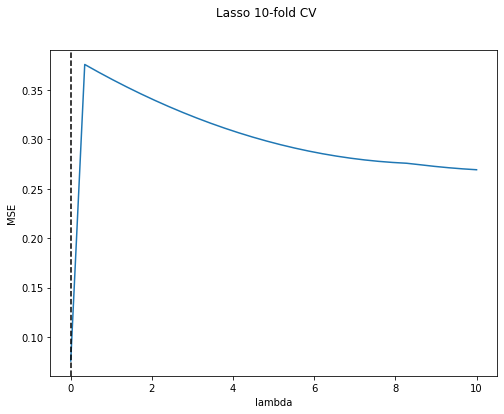

In [ ]:
# Plot MSE vs Lambda
fig, (ax1) = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Lasso 10-fold CV')

ax1.plot(alphas, MSE);
ax1.axvline(alpha_min, c='k', ls='--')
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

### same procedure using dropped NAs *dataset*

In [ ]:
# Init alpha grid
n_grid = 30
alphas = 10**np.linspace(-10, 0 ,n_grid).reshape(-1,1)
lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_drop_scaled, y_train_drop)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.reshape(lasso_coefs,(n_grid,-1))

In [ ]:
# Loop through all lambdas/alphas
n_grid = 30
alphas = 10**np.linspace(-10, 0 ,n_grid).reshape(-1,1)
MSE = [cv_lasso(X_train_drop_scaled,y_train_drop.values,a) for a in alphas]  

# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]

In [ ]:
print('Best alpha by 10fold CV:',alpha_min[0])
print('MSE for best alpha dropping NAs:', min(MSE))

Best alpha by 10fold CV: 6.723357536499335e-06
MSE for best alpha dropping NAs: 0.058664484307437335


In [ ]:
# Fitting the model
lasso = Lasso(alpha = 1.3738237958832638e-06).fit(X_train_scaled, y_train)

# Predicting
y_hat_lasso = lasso.predict(X_test_scaled)
MSE_hat = mean_squared_error(y_test, y_hat_lasso)
print(MSE_hat)

0.07097366043688534


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.026124731755, tolerance: 0.5842778405309895
  positive)


In [ ]:
# Fitting the model
lasso = Lasso(alpha = 6.723357536499335e-06).fit(X_train_drop_scaled, y_train_drop)

# Predicting
y_hat_lasso = lasso.predict(X_test_drop_scaled)
MSE_hat = mean_squared_error(y_test_drop, y_hat_lasso)
print(MSE_hat)

0.06787391838077164


## Ridge

In [ ]:
# Init alpha grid
n_grid = 30
alphas = 10**np.linspace(0, 10 ,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

def cv_ridge(X,y,a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    kf10.get_n_splits(X)

    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge = Ridge(alpha = a).fit(X_train, y_train)
        y_hat = ridge.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))

    return np.mean(mse)

In [ ]:
# Loop through all lambdas/alphas
n_grid = 30
alphas = np.linspace(0, 10 ,n_grid).reshape(-1,1)
MSE_ridge = [cv_ridge(X_train_scaled, y_train.values , a) for a in alphas]  

# Find minimum alpha
alpha_min_ridge = alphas[np.argmin(MSE_ridge)]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.94483e-24): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.58598e-22): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.71279e-23): result may not be accurate.
  overwrite_a=True).T


In [ ]:
print('Best alpha by 10fold CV:', alpha_min_ridge[0])
print('MSE for best alpha:', min(MSE_ridge))

Best alpha by 10fold CV: 0.0
MSE for best alpha: 0.07515475128713386


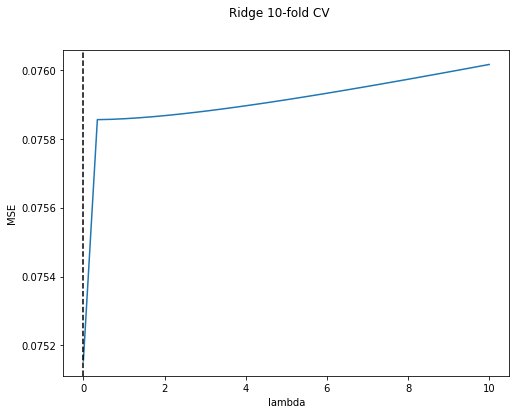

In [ ]:
# Plot MSE vs Lambda
fig, (ax1) = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle('Ridge 10-fold CV')

ax1.plot(alphas, MSE_ridge)
ax1.axvline(alpha_min_ridge, c='k', ls='--')
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

In [ ]:
# Fitting the model
ridge = Ridge(alpha = alpha_min_ridge[0]).fit(X_train, y_train)

# Predicting
y_hat_ridge = ridge.predict(X_test)
MSE = mean_squared_error(y_test, y_hat_ridge)
print(MSE)

0.07097077024090506


## Ridge with dropping NAs

In [ ]:
# Init alpha grid
n_grid = 30
alphas = 10**np.linspace(-5, 3 ,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train_drop_scaled, y_train_drop)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

def cv_ridge(X,y,a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    kf10.get_n_splits(X)

    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge = Ridge(alpha = a).fit(X_train, y_train)
        y_hat = ridge.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))

    return np.mean(mse)

In [ ]:
# Loop through all lambdas/alphas
n_grid = 30
alphas = 10**np.linspace(-5, 3 ,n_grid).reshape(-1,1)
MSE_ridge = [cv_ridge(X_train_drop_scaled, y_train_drop.values , a) for a in alphas]  

# Find minimum alpha
alpha_min_ridge = alphas[np.argmin(MSE_ridge)]

In [ ]:
print('Best alpha by 10fold CV:', alpha_min_ridge[0])
print('MSE for best alpha dropping NAs:', min(MSE_ridge))

Best alpha by 10fold CV: 0.2592943797404667
MSE for best alpha dropping NAs: 0.05866313997917105


In [ ]:
# Fitting the model
ridge = Ridge(alpha = 0.2592943797404667).fit(X_train_drop_scaled, y_train_drop)

# Predicting
y_hat_ridge = ridge.predict(X_test_drop)
MSE = mean_squared_error(y_test_drop, y_hat_ridge)
print(MSE)

0.06787184808660754


## XGboost

In [ ]:
# Using MSE as an error metric
def cv_mse(model, X=X_train):
    mse = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)
    return (mse)

In [ ]:
# We use K-fold Cross validation to find the best RMSE for the tuned model
kf = KFold(n_splits=10, random_state=0)

GBoost = XGBRegressor(n_estimators=6000, 
                                   learning_rate=0.01,
                                   max_depth=4, 
                                   max_features='sqrt',
                                   min_samples_leaf=15, 
                                   min_samples_split=10, 
                                   loss='huber', 
                                   random_state =42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
errors = {}

In [ ]:
from sklearn.model_selection import cross_val_score
error = cv_mse(GBoost)
print("MSE of Gradient Boosting Model:" , error.mean())

[23:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

NameError: ignored

In [ ]:
errors['Gradient Boosting'] = (error.mean(), error.std())

NameError: ignored

## XGboost with dropped NAs

In [ ]:
# Using MSE as an error metric
def cv_mse(model, X_train,y_train):
    mse = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)
    return (mse)

In [ ]:
# We use K-fold Cross validation to find the best RMSE for the tuned model
kf = KFold(n_splits=10, random_state=0)

GBoost = XGBRegressor(n_estimators=7000, 
                                   learning_rate=0.05,
                                   max_depth=5, 
                                   max_features='sqrt',
                                   min_samples_leaf=13, 
                                   min_samples_split=11, 
                                   loss='huber', 
                                   random_state =42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
from sklearn.model_selection import cross_val_score
error = cv_mse(GBoost, X_train_drop_scaled, y_train_drop)
print("MSE of Gradient Boosting Model:" , error.mean())
errors['Gradient Boosting'] = (error.mean(), error.std())

[07:19:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:22:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:31:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Random Forest Regressor

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# We use K-fold Cross validation to find the best RMSE using the best parameters
kf = KFold(n_splits=10, random_state=0)

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# Using MSE as an error metric
def cv_mse(model, X=X_train):
    mse = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)
    return (mse)

In [ ]:
error = cv_mse(rf)

In [ ]:
print("RMSE of Random Forest Model:" , error.mean())
errors['RF'] = (error.mean(), error.std())

RMSE of Random Forest Model: 0.04376285356761435


## Random Forest Regressor with dropped NAs

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# We use K-fold Cross validation to find the best RMSE using the best parameters
kf = KFold(n_splits=10, random_state=0)

rf = RandomForestRegressor(n_estimators=1500,
                          max_depth=12,
                          min_samples_split=6,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# Using MSE as an error metric
def cv_mse(model):
    mse = -cross_val_score(model, X_train_drop_scaled, y_train_drop, scoring="neg_mean_squared_error", cv=kf)
    return (mse)

In [ ]:
error = cv_mse(rf)

In [ ]:
print("RMSE of Random Forest Model:" , error.mean())
errors['RF'] = (error.mean(), error.std())

RMSE of Random Forest Model: 0.0377706365257911


# DDML

In [ ]:
# Add constant term to the dataset -> for OLS, we need a constant to not make our model biased
df_imputed['const'] = 1

In [ ]:
df_imputed["Price"] = y_pds

In [ ]:
df_imputed["Price"]

1        1480000.0
2        1035000.0
4        1465000.0
5         850000.0
6        1600000.0
           ...    
34852    1480000.0
34853     888000.0
34854     705000.0
34855    1140000.0
34856    1020000.0
Name: Price, Length: 27247, dtype: float64

In [ ]:
# drop dummy per category (collinearity)
df_drop = df_imputed.drop(['CouncilArea_Banyule City Council', 'Regionname_Eastern Metropolitan', 'Type_h', 'season_fall'], axis = 1)

In [ ]:
# Create lists of variables to be used in each regression
X1 = df_drop[['const','Rooms',	'Distance',	'Bathroom',	'Car',	'Landsize',	'BuildingArea',	'houseAge']]
X3 = df_drop[['const','Rooms',	'Distance',	'Bathroom',	'Car',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude',	'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']]
y = df_drop['Price']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

In [ ]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2'],
                            info_dict=info_dict,
                            regressor_order=['const','Rooms',	'Distance',	'Bathroom',	'Car',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude'])

results_table

,Model 1,Model 2
const,-149679.91***,-4288630.69
,(13452.33),(7287671.10)
Rooms,288363.92***,310737.95***
,(3932.21),(3494.34)
Distance,-31310.65***,-33165.16***
,(477.71),(1033.55)
Bathroom,215377.32***,141660.05***
,(5926.65),(5230.43)
Car,42578.09***,43513.17***
,(3785.48),(3293.18)


In [ ]:
def estimate_beta(algorithm, alg_name, D, X, y, sample):

    # Split sample
    D_main, D_aux = (D[sample==1], D[sample==0])
    X_main, X_aux = (X[sample==1], X[sample==0])
    y_main, y_aux = (y[sample==1], y[sample==0])

    # Residualize y on D
    b_hat = inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    y_resid_aux = y_aux - D_aux @ b_hat
    
    # Estimate g0
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid_aux.ravel())
    g0 = alg_fitted.predict(X_main).reshape(-1,1)

    # Compute v_hat
    u_hat = y_main - g0

    # Estimate m0
    alg_fitted = algorithm.fit(X=X_aux, y=D_aux.ravel())
    m0 = algorithm.predict(X_main).reshape(-1,1)
    
    # Compute u_hat
    v_hat = D_main - m0

    # Estimate beta
    beta = inv(v_hat.T @ D_main) @ v_hat.T @ u_hat
        
    return beta


In [ ]:
def ddml(algorithm, alg_name, D, X, y, p=0.5, verbose=False):
  

    # Generate split (fixed proportions)
    split = split = np.random.binomial(1, p, len(D))
    
    # Compute beta
    beta = [estimate_beta(algorithm, alg_name, D, X, y, split==k) for k in range(2)]
    beta = np.mean(beta)
     
    # Print and return
    if verbose:
        print('%s : %.4f' % (alg_name, beta))
    return beta

In [ ]:
# List all algorithms
algorithms = {'Ridge   ': Ridge(alpha=.1),
              'Lasso   ': Lasso(alpha=.01),
              'Tree    ': DecisionTreeRegressor(),
              'Forest  ': RandomForestRegressor(n_estimators=30),
              'Boosting': GradientBoostingRegressor(n_estimators=30)}
#algorithms = {'Ridge   ': Ridge(alpha=.1),
#              'Lasso   ': Lasso(alpha=.01),}

In [ ]:
# Repeat K times
def estimate_beta_median(algorithms, D, X, y, K):
    
    # Loop over algorithms
    for alg_name, algorithm in algorithms.items():
        betas = []
            
        # Iterate n times
        for k in range(K):
            beta = ddml(algorithm, alg_name, D, X, y)
            betas = np.append(betas, beta)
    
        print('%s : %.4f' % (alg_name, np.median(betas)))

### DDML on Rooms

In [ ]:
D = df_drop['Rooms'].values.reshape(-1,1)
X = df_drop[['const', 'Distance',	'Bathroom',	'Car',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

In [ ]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : 377832.5559
Lasso    : 381048.0956
Tree     : 193110.6336
Forest   : 202653.8783
Boosting : 261628.3419


### DDML on Distance

In [ ]:
D = df_drop['Distance'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Bathroom',	'Car',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

Ridge    : -37173.8367
Lasso    : -5498.6165
Tree     : -50390.8283
Forest   : -24592.2591
Boosting : 3444.9323


In [ ]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : -36134.8178
Lasso    : -5628.8649
Tree     : -39136.8842
Forest   : -28972.9286
Boosting : 3424.4861


### DDML on Bathroom

In [ ]:
D = df_drop['Bathroom'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Distance',	'Car',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

Ridge    : 22932.8230
Lasso    : 31022.4204
Tree     : 44153.0907
Forest   : 55399.7434
Boosting : 144735.3895


In [ ]:
np.random.seed(123)

# Repeat 10 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : 131258.6512
Lasso    : 158450.0271
Tree     : 47559.3440
Forest   : 72785.2168
Boosting : 181235.2589


### DDML on Car

In [ ]:
D = df_drop['Car'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Distance',	'Bathroom',	'Landsize',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

Ridge    : 30134.7458
Lasso    : 39942.8313
Tree     : -40503.6093
Forest   : -15426.3726
Boosting : 42102.4772


In [ ]:
np.random.seed(123)

# Repeat 10 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : 50417.4622
Lasso    : 66950.4300
Tree     : -34585.2437
Forest   : -8046.8868
Boosting : 50163.7691


### DDML on Landsize

In [ ]:
D = df_drop['Landsize'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Distance',	'Bathroom',	'Car',	'BuildingArea',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

Ridge    : 1.5931
Lasso    : -4.7739
Tree     : 5.4723
Forest   : -17.5996
Boosting : -74.9553


In [ ]:
np.random.seed(123)

# Repeat 10 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : -0.9438
Lasso    : -2.2267
Tree     : -12.0122
Forest   : -12.0490
Boosting : -0.0384


### DDML on BuildingArea

In [ ]:
D = df_drop['BuildingArea'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Distance',	'Bathroom',	'Car',	'Landsize',	'houseAge', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

In [ ]:
np.random.seed(123)

# Repeat 10 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : -1268.8005
Lasso    : -1563.8055
Tree     : 64.7753
Forest   : -1990.9485
Boosting : -410.2187


### DDML on houseAge

In [ ]:
D = df_drop['houseAge'].values.reshape(-1,1)
X = df_drop[['const', 'Rooms',	'Distance',	'Bathroom',	'Car',	'Landsize',	'BuildingArea', 'Lattitude',	'Longtitude', 'CouncilArea_Bayside City Council',	'CouncilArea_Boroondara City Council',	'CouncilArea_Brimbank City Council',	'CouncilArea_Cardinia Shire Council',	'CouncilArea_Casey City Council',	'CouncilArea_Darebin City Council',	'CouncilArea_Frankston City Council',	'CouncilArea_Glen Eira City Council',	'CouncilArea_Greater Dandenong City Council',	'CouncilArea_Hobsons Bay City Council',	'CouncilArea_Hume City Council',	'CouncilArea_Kingston City Council',	'CouncilArea_Knox City Council',	'CouncilArea_Macedon Ranges Shire Council',	'CouncilArea_Manningham City Council',	'CouncilArea_Maribyrnong City Council',	'CouncilArea_Maroondah City Council',	'CouncilArea_Melbourne City Council',	'CouncilArea_Melton City Council',	'CouncilArea_Mitchell Shire Council',	'CouncilArea_Monash City Council',	'CouncilArea_Moonee Valley City Council',	'CouncilArea_Moorabool Shire Council',	'CouncilArea_Moreland City Council',	'CouncilArea_Nillumbik Shire Council',	'CouncilArea_Port Phillip City Council',	'CouncilArea_Stonnington City Council',	'CouncilArea_Whitehorse City Council',	'CouncilArea_Whittlesea City Council',	'CouncilArea_Wyndham City Council',	'CouncilArea_Yarra City Council',	'CouncilArea_Yarra Ranges Shire Council',	'Regionname_Eastern Victoria',	'Regionname_Northern Metropolitan',	'Regionname_Northern Victoria',	'Regionname_South-Eastern Metropolitan',	'Regionname_Southern Metropolitan',	'Regionname_Western Metropolitan',	'Regionname_Western Victoria',	'season_spring',	'season_summer',	'season_winter',	'Type_t']].values
y = df_drop['Price'].values.reshape(-1,1)

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, verbose=True)

In [ ]:
np.random.seed(123)

# Repeat 10 times and take median
estimate_beta_median(algorithms, D, X, y, 100)

Ridge    : 2960.2308
Lasso    : 3158.5479
Tree     : 455.2668
Forest   : 1533.7437
Boosting : 4377.5669
